In [1]:
import pandas as pd

full_df = pd.read_csv('sentiment140.csv', encoding = "ISO-8859-1", engine='python', header = None)
full_df.columns=['sentiment', 'id','date', 'query','user','text']
full_df.head(5)

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [2]:
import re
import string
import spacy
size = int(len(full_df)*.01)

df = full_df.sample(n= size, random_state=1)

# Load the small model
nlp = spacy.load("en_core_web_sm")

stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Creating our tokenzer function from a given sentence/review
def clean_text(sentence):
    # Remove nan, @airline, punctuation, URL, or any non alpanumeric characters and seperate word using a single space.
    sentence = ' '.join(re.sub("(nan)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence).split())
    # Removing stop words and obtain the lemma
    text = [ word.lemma_ for word in nlp(sentence) if word not in stop_words]
    return ' '.join(text).strip().lower()

# Apply clean_text function to the column.
df['text_review_cleaned'] = df['text'].apply(clean_text)

In [3]:
print(size)

16000


In [4]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

sentiment              0.0
id                     0.0
date                   0.0
query                  0.0
user                   0.0
text                   0.0
text_review_cleaned    0.0
dtype: float64

In [5]:
df["len_text_bc"] = df['text'].str.len()
df["len_text_ac"] = df["text_review_cleaned"].str.len()

# Set the format of numerical values for Pandas library
# It only shows two decimal places
pd.options.display.float_format = "{:.2f}".format
df[["len_text_bc", "len_text_ac"]].describe()

,len_text_bc,len_text_ac
count,16000.00,16000.00
mean,73.72,60.82
std,36.24,33.41
min,6.00,0.00
25%,44.00,33.00
50%,69.00,56.00
75%,103.00,87.00
max,165.00,149.00


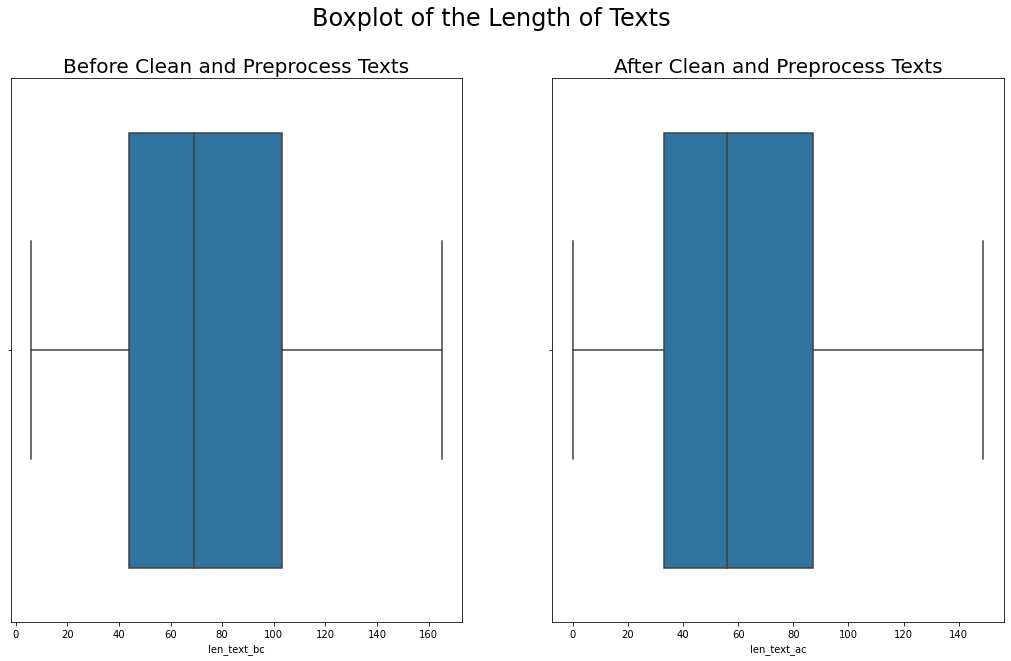

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize = (17.8, 10))
fig.suptitle('Boxplot of the Length of Texts', fontsize= 24)

# Plot the texts before cleaning
sns.boxplot(ax=axes[0], x=df["len_text_bc"])
axes[0].set_title("Before Clean and Preprocess Texts", fontsize= 20)
# Plot the texts after cleaning
sns.boxplot(ax=axes[1], x=df["len_text_ac"])
x= axes[1].set_title("After Clean and Preprocess Texts", fontsize= 20)

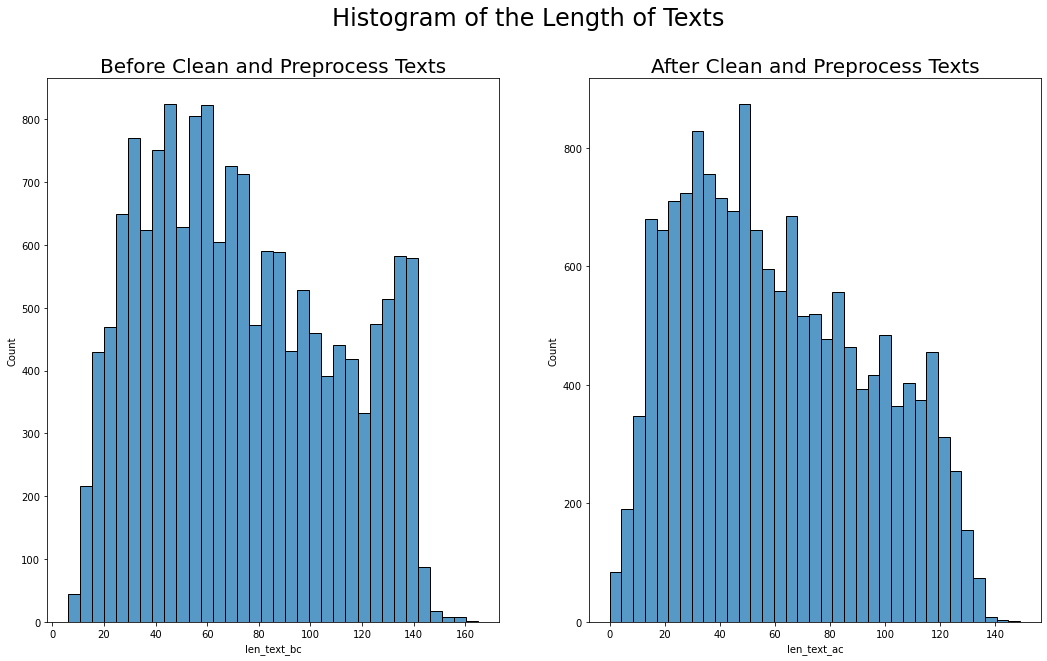

In [7]:


fig, axes = plt.subplots(1, 2, figsize = (17.8, 10))
fig.suptitle('Histogram of the Length of Texts', fontsize= 24)

# Plot the texts before cleaning
sns.histplot(ax=axes[0], data = df, x="len_text_bc")
axes[0].set_title("Before Clean and Preprocess Texts", fontsize= 20)
# Plot the texts after cleaning
sns.histplot(ax=axes[1], data = df, x="len_text_ac")
x= axes[1].set_title("After Clean and Preprocess Texts", fontsize= 20)



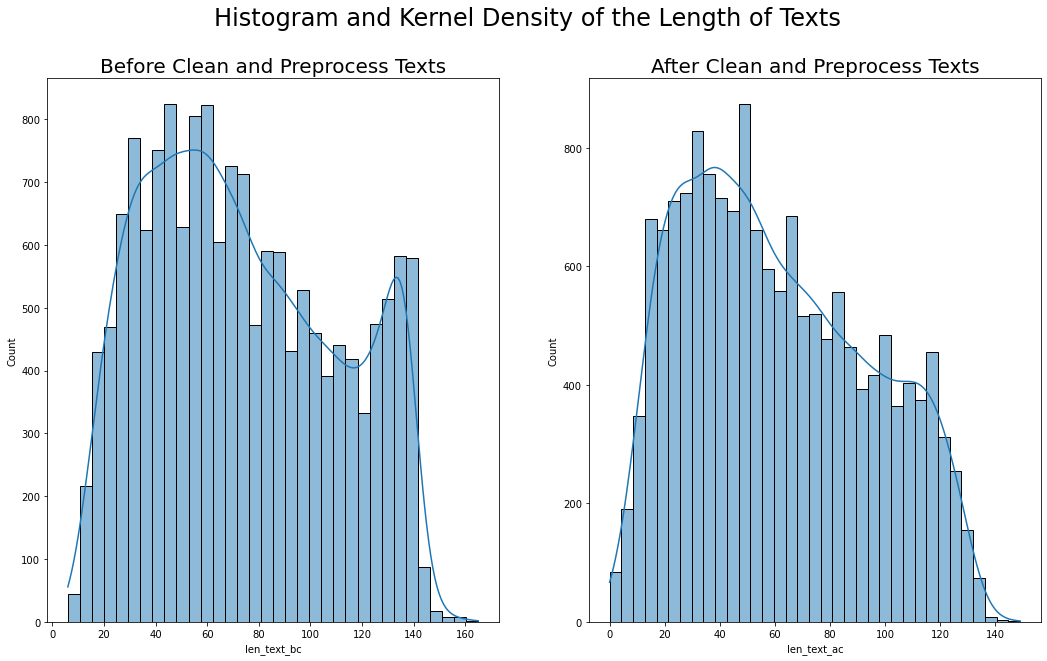

In [8]:


fig, axes = plt.subplots(1, 2, figsize = (17.8, 10))
fig.suptitle('Histogram and Kernel Density of the Length of Texts', fontsize= 24)

sns.histplot(ax=axes[0], data = df, x="len_text_bc", kde = True)
axes[0].set_title("Before Clean and Preprocess Texts", fontsize= 20)

sns.histplot(ax=axes[1], data = df, x="len_text_ac", kde = True)
x= axes[1].set_title("After Clean and Preprocess Texts", fontsize= 20)



In [9]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a function returning the top words
def get_top_tf_idf_words(df = df, col = "text_review", use_idf = True, ngram_range =(1, 1), top_n= 5):
    
    tf_idf = TfidfVectorizer(stop_words='english', ngram_range = ngram_range, use_idf = use_idf)
    # Fit and transform the corpus
    X_sparse_matrix = tf_idf.fit_transform(df[col])
    feature_names = np.array(tf_idf.get_feature_names())
    # Generate the tf-idf matrix
    tf_idf_sparse_matrix = tf_idf.transform(df[col])
    # Rank the matrix by tf-idf values and return the indices of the top_n values
    sorted_idx = np.argsort(tf_idf_sparse_matrix.data)[:-(top_n+1):-1]
    
    # Return the feature names and corresponding tf_idf values in a df
    return pd.DataFrame(
    {'feature': feature_names[tf_idf_sparse_matrix.indices[sorted_idx]],
     'tf_idf': tf_idf_sparse_matrix.data[sorted_idx],
    })

top_n = 10
# Generate top tf-idf words for the texts before and after cleaning
df_text_bc = get_top_tf_idf_words(df = df, col = 'text', top_n= top_n)
df_text_ac = get_top_tf_idf_words(df = df, col = "text_review_cleaned", top_n= top_n)

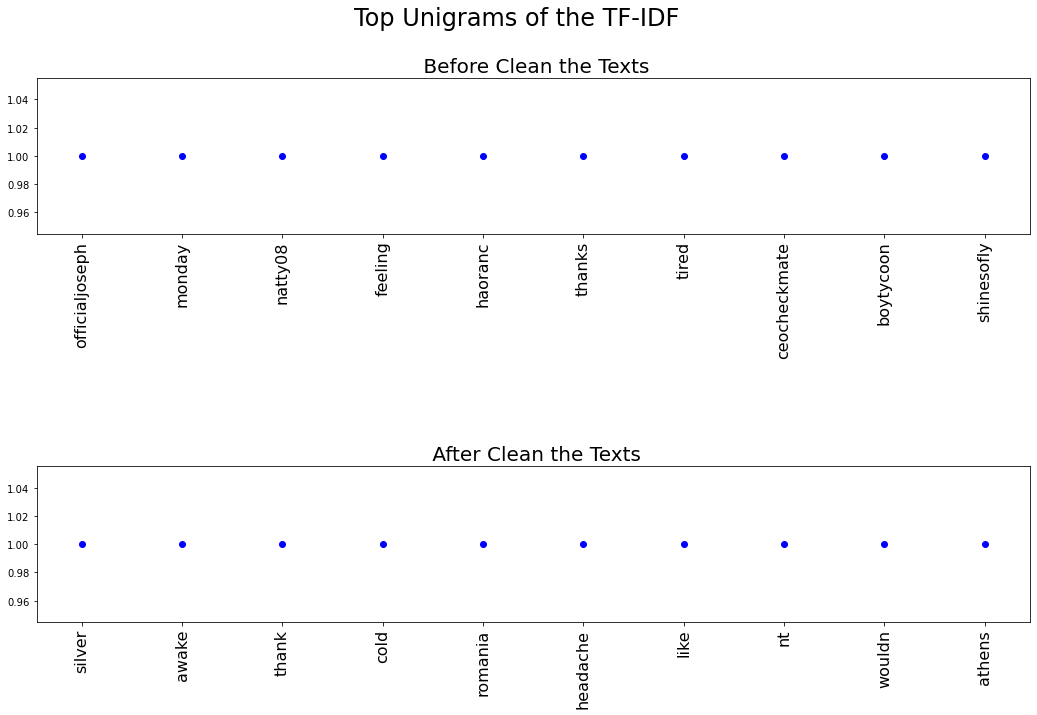

In [10]:
import matplotlib.pyplot as plt

x=range(0, top_n)

fig, ax = plt.subplots(2, 1, figsize = (17.8, 10))

fig.suptitle('Top Unigrams of the TF-IDF', fontsize= 24)

# Plot x and tf_idf using blue circle markers
ax[0].plot(x, df_text_bc.tf_idf, 'bo')
ax[0].set_title(' Before Clean the Texts', fontsize= 20)
# Set number of ticks for x-axis
ax[0].set_xticks(x)
# Set ticks labels for x-axis
x_ticks_labels = df_text_bc.feature
ax[0].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

# Plot x and tf_idf using blue circle markers
ax[1].plot(x, df_text_ac.tf_idf, 'bo')
ax[1].set_title(' After Clean the Texts', fontsize= 20)
# Set number of ticks for x-axis
ax[1].set_xticks(x)
# Set ticks labels for x-axis
x_ticks_labels = df_text_ac.feature
ax[1].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

# Adjust horizontal space
fig.subplots_adjust(hspace=1.5)
plt.show()

In [11]:
# Define a function returning the top words
def get_top_tf_idf_bigram(df = df, col = "text_review", use_idf = True, ngram_range =(2, 2), top_n= 5):
    
    tf_idf = TfidfVectorizer(stop_words='english', ngram_range = ngram_range, use_idf = use_idf)
    # Fit and transform the corpus
    X_sparse_matrix = tf_idf.fit_transform(df[col])
    feature_names = np.array(tf_idf.get_feature_names())
    # Generate the tf-idf matrix
    tf_idf_sparse_matrix = tf_idf.transform(df[col])
    # Rank the matrix by tf-idf values and return the indices of the top_n values
    sorted_idx = np.argsort(tf_idf_sparse_matrix.data)[:-(top_n+1):-1]
    
    # Return the feature names and corresponding tf_idf values in a df
    return pd.DataFrame(
    {'feature': feature_names[tf_idf_sparse_matrix.indices[sorted_idx]],
     'tf_idf': tf_idf_sparse_matrix.data[sorted_idx],
    })

top_n = 10
# Generate top tf-idf words for the texts before and after cleaning
df_text_bc = get_top_tf_idf_bigram(df = df, col = 'text', top_n= top_n)
df_text_ac = get_top_tf_idf_bigram(df = df, col = "text_review_cleaned", top_n= top_n)

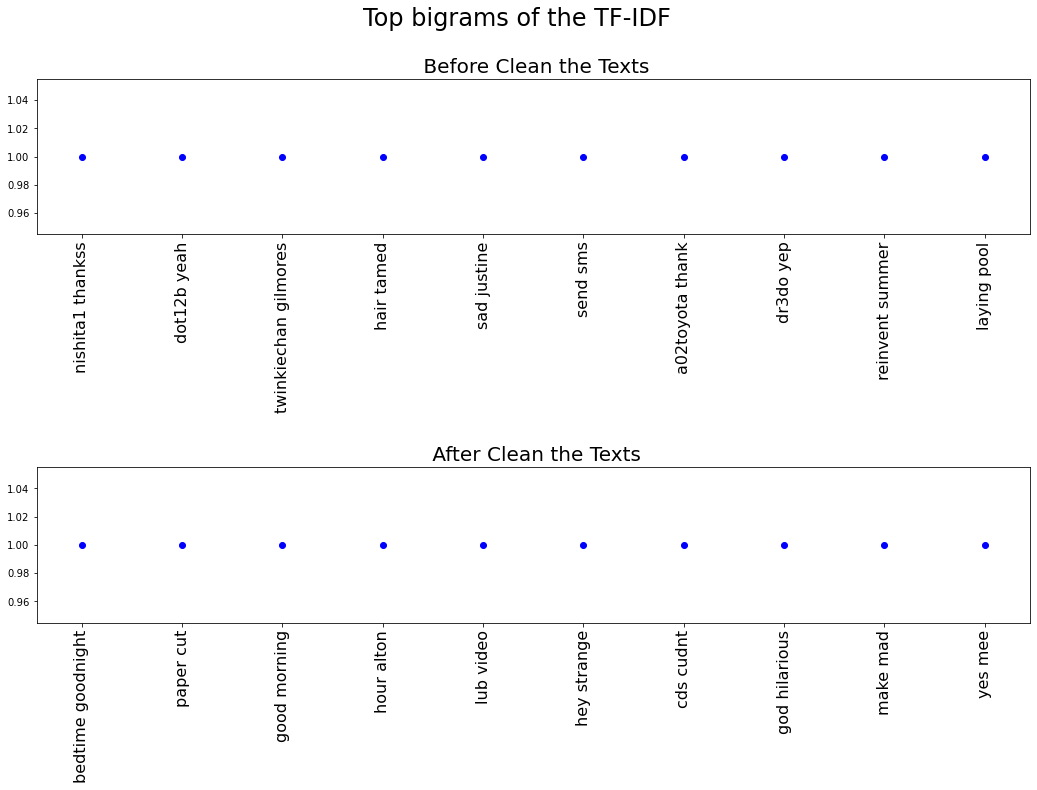

In [12]:
x=range(0, top_n)

fig, ax = plt.subplots(2, 1, figsize = (17.8, 10))

fig.suptitle('Top bigrams of the TF-IDF', fontsize= 24)

# Plot x and tf_idf using blue circle markers
ax[0].plot(x, df_text_bc.tf_idf, 'bo')
ax[0].set_title(' Before Clean the Texts', fontsize= 20)
# Set number of ticks for x-axis
ax[0].set_xticks(x)
# Set ticks labels for x-axis
x_ticks_labels = df_text_bc.feature
ax[0].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

# Plot x and tf_idf using blue circle markers
ax[1].plot(x, df_text_ac.tf_idf, 'bo')
ax[1].set_title(' After Clean the Texts', fontsize= 20)
# Set number of ticks for x-axis
ax[1].set_xticks(x)
# Set ticks labels for x-axis
x_ticks_labels = df_text_ac.feature
ax[1].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

# Adjust horizontal space
fig.subplots_adjust(hspace=1.5)
plt.show()

In [13]:
# Use the scattetext and spaCy libraries
import scattertext as st
import spacy
from pprint import pprint

# Load the small model of spaCy
nlp = spacy.load("en_core_web_sm")

# Generate corpus before cleaning texts
corpus_bc = st.CorpusFromPandas(df, 
                              category_col='sentiment', 
                              text_col='text',
                              nlp=nlp).build()
# Generate corpus after cleaning texts
corpus_ac = st.CorpusFromPandas(df, 
                              category_col='sentiment', 
                              text_col='text_review_cleaned',
                              nlp=nlp).build()

In [14]:
# Create the term frequence for the sentiment before cleaning the texts
term_freq_df_bc = corpus_bc.get_term_freq_df()
# Create the negative score for the sentiment of positive review before cleaning the texts
term_freq_df_bc['negative Score'] = corpus_bc.get_scaled_f_scores(0)

#term_freq_df_bc.head(5)

# Rank them by descending order
term_freq_df_bc_freq = term_freq_df_bc.sort_values(by= '0 freq', ascending=False)
term_freq_df_bc_Score = term_freq_df_bc.sort_values(by= 'negative Score', ascending=False)

# Create the term frequence for the sentiment after cleaning the texts
term_freq_df_ac = corpus_ac.get_term_freq_df()
# Create the positive score for the sentiment of positive review after cleaning the texts
term_freq_df_ac['negative Score'] = corpus_ac.get_scaled_f_scores(0)
# Rank them by descending order
term_freq_df_ac_freq = term_freq_df_ac.sort_values(by= '0 freq', ascending=False)
term_freq_df_ac_Score = term_freq_df_ac.sort_values(by= 'negative Score', ascending=False)

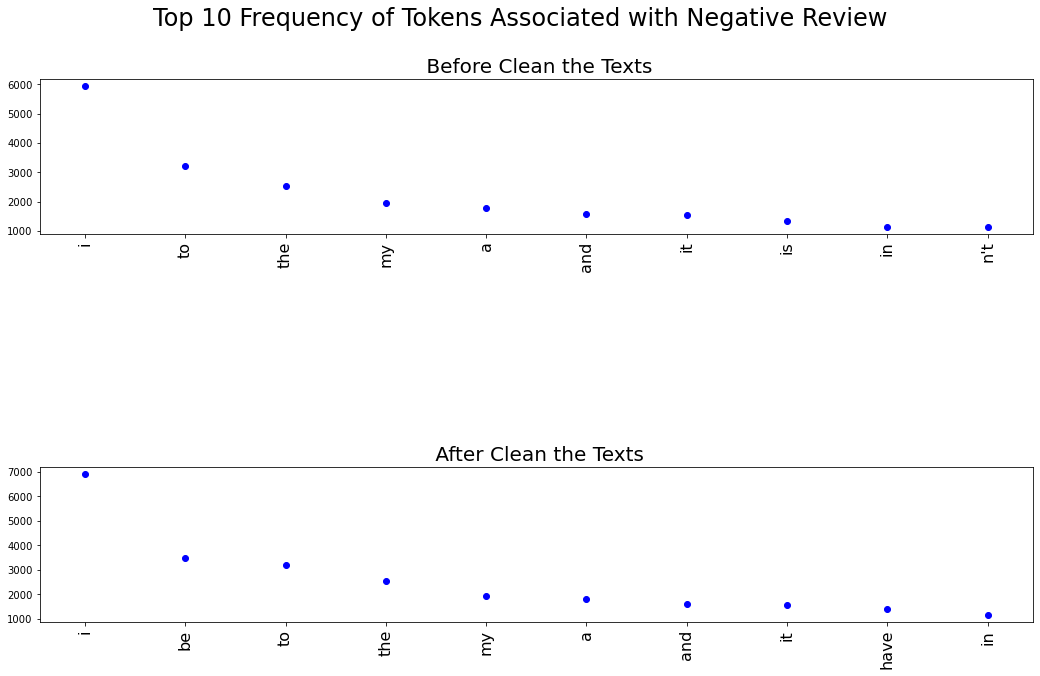

In [15]:
# Specify the top n tokens to plot
top_n = 10
term_freq_df_ac_freq = term_freq_df_ac_freq.head(10)
term_freq_df_bc_freq = term_freq_df_bc_freq.head(10)
x = range(0, top_n)

fig, ax = plt.subplots(2, 1, figsize = (17.8, 10))

fig.suptitle('Top 10 Frequency of Tokens Associated with Negative Review', fontsize= 24)

# Plot x and tf using blue circle markers
ax[0].plot(x, term_freq_df_bc_freq["0 freq"], 'bo')
ax[0].set_title(' Before Clean the Texts', fontsize= 20)
# Set number of ticks for x-axis
ax[0].set_xticks(x)
# Set ticks labels for x-axis to be the tokens
x_ticks_labels = term_freq_df_bc_freq.index
ax[0].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

# Plot x and tf using blue circle markers
ax[1].plot(x, term_freq_df_ac_freq["0 freq"], 'bo')
ax[1].set_title(' After Clean the Texts', fontsize= 20)
# Set number of ticks for x-axis
ax[1].set_xticks(x)
# Set ticks labels for x-axis
x_ticks_labels = term_freq_df_ac_freq.index
ax[1].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

# Adjust horizontal space
fig.subplots_adjust(hspace=1.5)
plt.show()

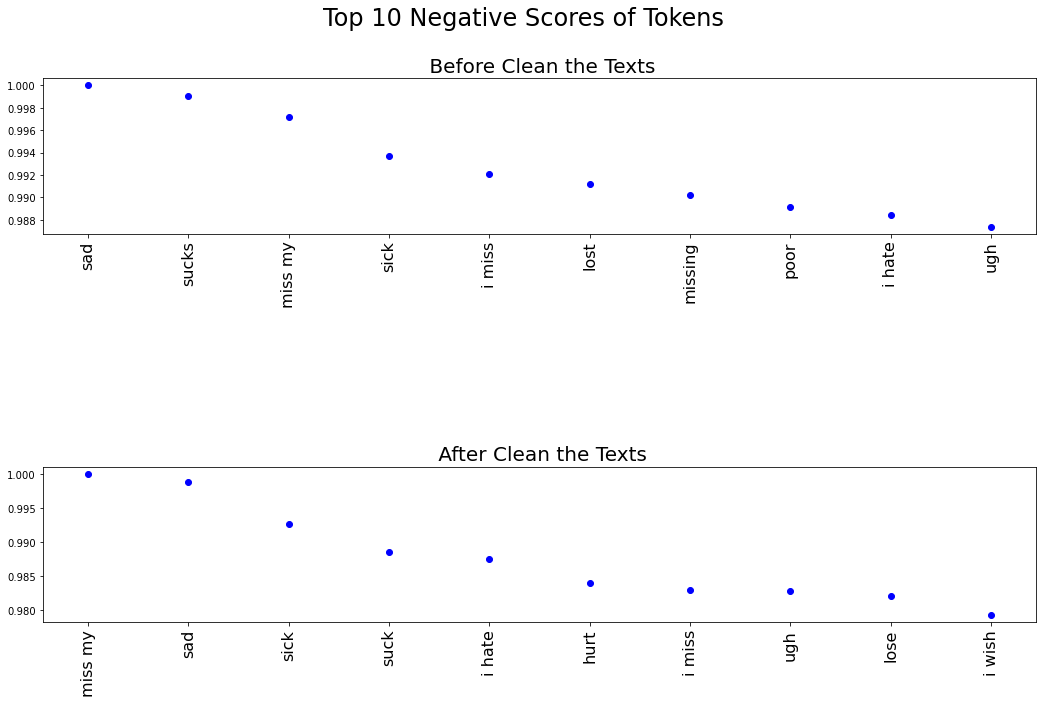

In [16]:

term_freq_df_ac_Score = term_freq_df_ac_Score.head(10)
term_freq_df_bc_Score = term_freq_df_bc_Score.head(10)
x = range(0, top_n)

fig, ax = plt.subplots(2, 1, figsize = (17.8, 10))

fig.suptitle('Top 10 Negative Scores of Tokens', fontsize= 24)

# Plot x and scores using blue circle markers
ax[0].plot(x, term_freq_df_bc_Score["negative Score"], 'bo')
ax[0].set_title(' Before Clean the Texts', fontsize= 20)
# Set number of ticks for x-axis
ax[0].set_xticks(x)
# Set ticks labels for x-axis to be the tokens
x_ticks_labels = term_freq_df_bc_Score.index
ax[0].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

# Plot x and scores using blue circle markers
ax[1].plot(x, term_freq_df_ac_Score["negative Score"], 'bo')
ax[1].set_title(' After Clean the Texts', fontsize= 20)
# Set number of ticks for x-axis
ax[1].set_xticks(x)
# Set ticks labels for x-axis to be the tokens
x_ticks_labels = term_freq_df_ac_Score.index
ax[1].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

# Adjust horizontal space
fig.subplots_adjust(hspace=1.5)
plt.show()




In [17]:
# Load the large model
nlp = spacy.load("en_core_web_lg")

data_bc = []
data_ac = []

# Generate only the first 10 sentence/doc embeddings
top_n = 10
for idx, row in df.head(5).iterrows():
    
    data_ac.append([row['text_review_cleaned'], nlp(row['text_review_cleaned']).vector, row['sentiment']])
    data_bc.append([row['text'], nlp(row['text']).vector, row['sentiment']])
    
     


#print(data_ac)
df_ac = pd.DataFrame(data_ac, columns=['review_ac', "vector", "sentiment"])
df_bc = pd.DataFrame(data_bc, columns=['review_bc', "vector", "sentiment"])
pprint(df_ac)

                                           review_ac  \
0  i miss nikki nu nu already she s always there ...   
1  so i have a dream last night i remember a sign...   
2  ohh poor sickly you hug hope you feel a little...   
3                                   it be rain again   
4                          wish i be in la right now   

                                              vector  sentiment  
0  [0.054862205, 0.16253813, -0.09924347, -0.1891...          0  
1  [0.12990257, 0.21800943, -0.28877836, -0.04285...          0  
2  [-0.17000026, 0.15699157, -0.38396332, 0.03464...          0  
3  [0.09655648, 0.2992525, -0.10521676, -0.123259...          0  
4  [0.059872862, 0.080285296, -0.19888942, -0.205...          0  


In [18]:
from sklearn.decomposition import PCA 

# Convert the dataframe to a n-dimensional array
X_bc = np.array(list(df_bc["vector"]))
X_ac = np.array(list(df_ac["vector"]))

# Extract 2 principal componets using PCA
pca = PCA(n_components=2)
pca_bc_2d = pca.fit_transform(X_bc)
pca_ac_2d = pca.fit_transform(X_ac)




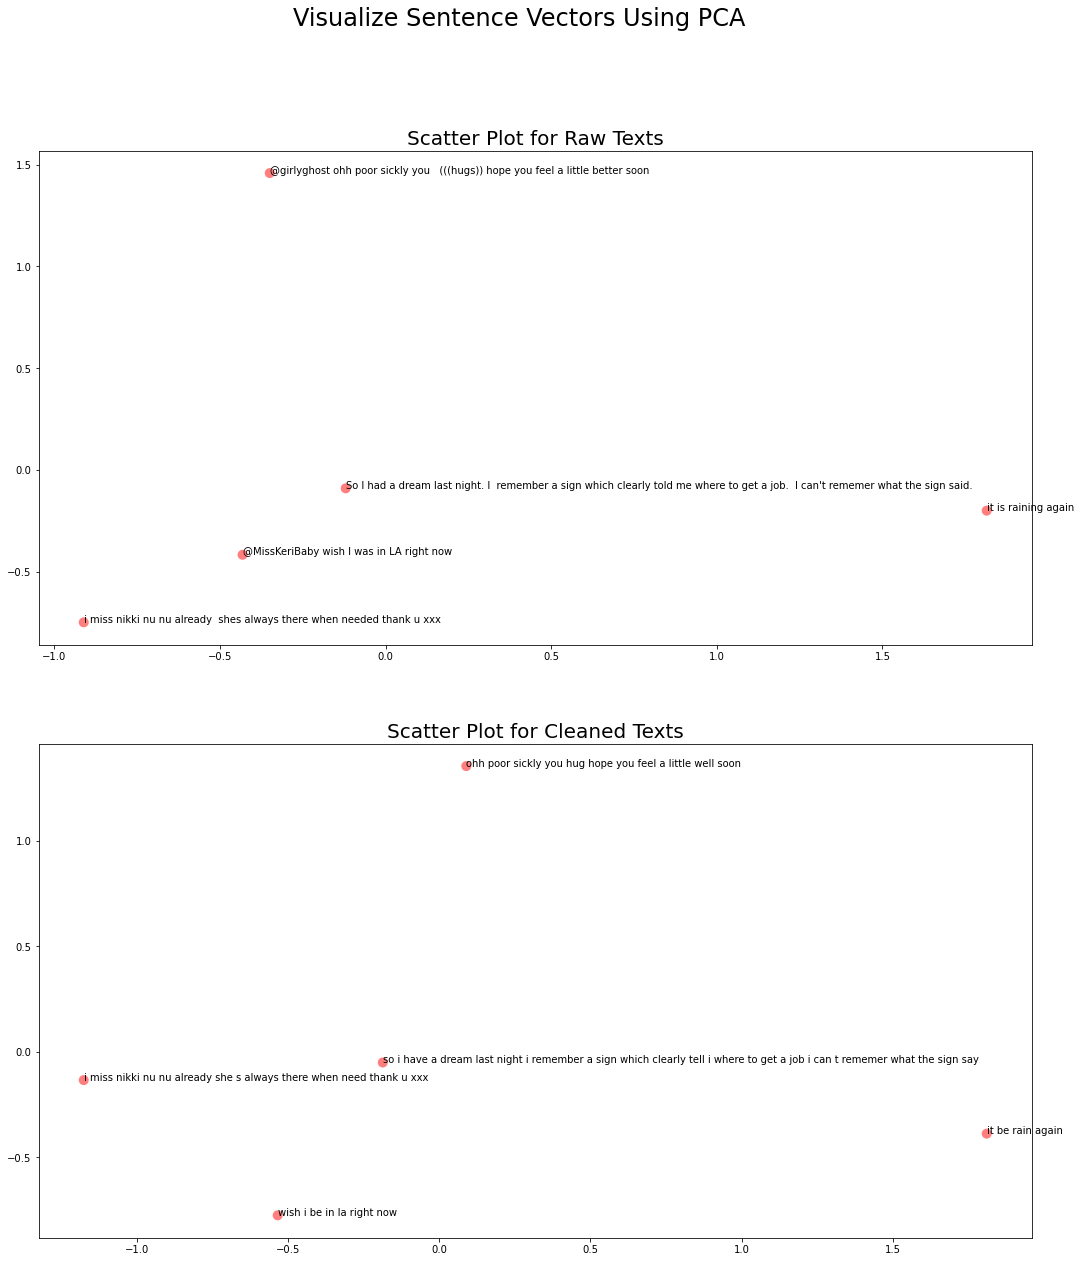

In [19]:
# Plot the  PCA visuals side-by-side
review_ac = df_ac.review_ac
review_bc = df_bc.review_bc

fig, ax = plt.subplots(2, 1, figsize = (17.8, 10*2))
fig.suptitle('Visualize Sentence Vectors Using PCA', fontsize= 24)
# Color the sentence embeddings based on the airline sentiment
colors = {4:'green', 0:'red', 2:'yellow'}

ax[0].scatter(pca_bc_2d[:,0],pca_bc_2d[:,1], s = 100,  c= df_bc["sentiment"].map(colors), 
            cmap = "coolwarm", edgecolor = "None", alpha=0.5)
ax[0].set_title('Scatter Plot for Raw Texts', fontsize= 20)
# Label the points using the texts
for idx, txt in enumerate(review_bc):
    ax[0].annotate(txt, (pca_bc_2d[idx, 0],pca_bc_2d[idx, 1]))

ax[1].scatter(pca_ac_2d[:,0],pca_ac_2d[:,1], s = 100,  c = df_ac["sentiment"].map(colors), 
            cmap = "coolwarm", edgecolor = "None", alpha=0.5)
# Label the points using the texts
for idx, txt in enumerate(review_ac):
    ax[1].annotate(txt, (pca_ac_2d[idx, 0],pca_ac_2d[idx, 1]))
ax[1].set_title('Scatter Plot for Cleaned Texts', fontsize= 20)
plt.show()

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 5 samples in 0.000s...
[t-SNE] Computed neighbors for 5 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.634960
[t-SNE] KL divergence after 4000 iterations: 0.110409
[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 5 samples in 0.000s...
[t-SNE] Computed neighbors for 5 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 34.845024
[t-SNE] KL divergence after 550 iterations: 0.110461


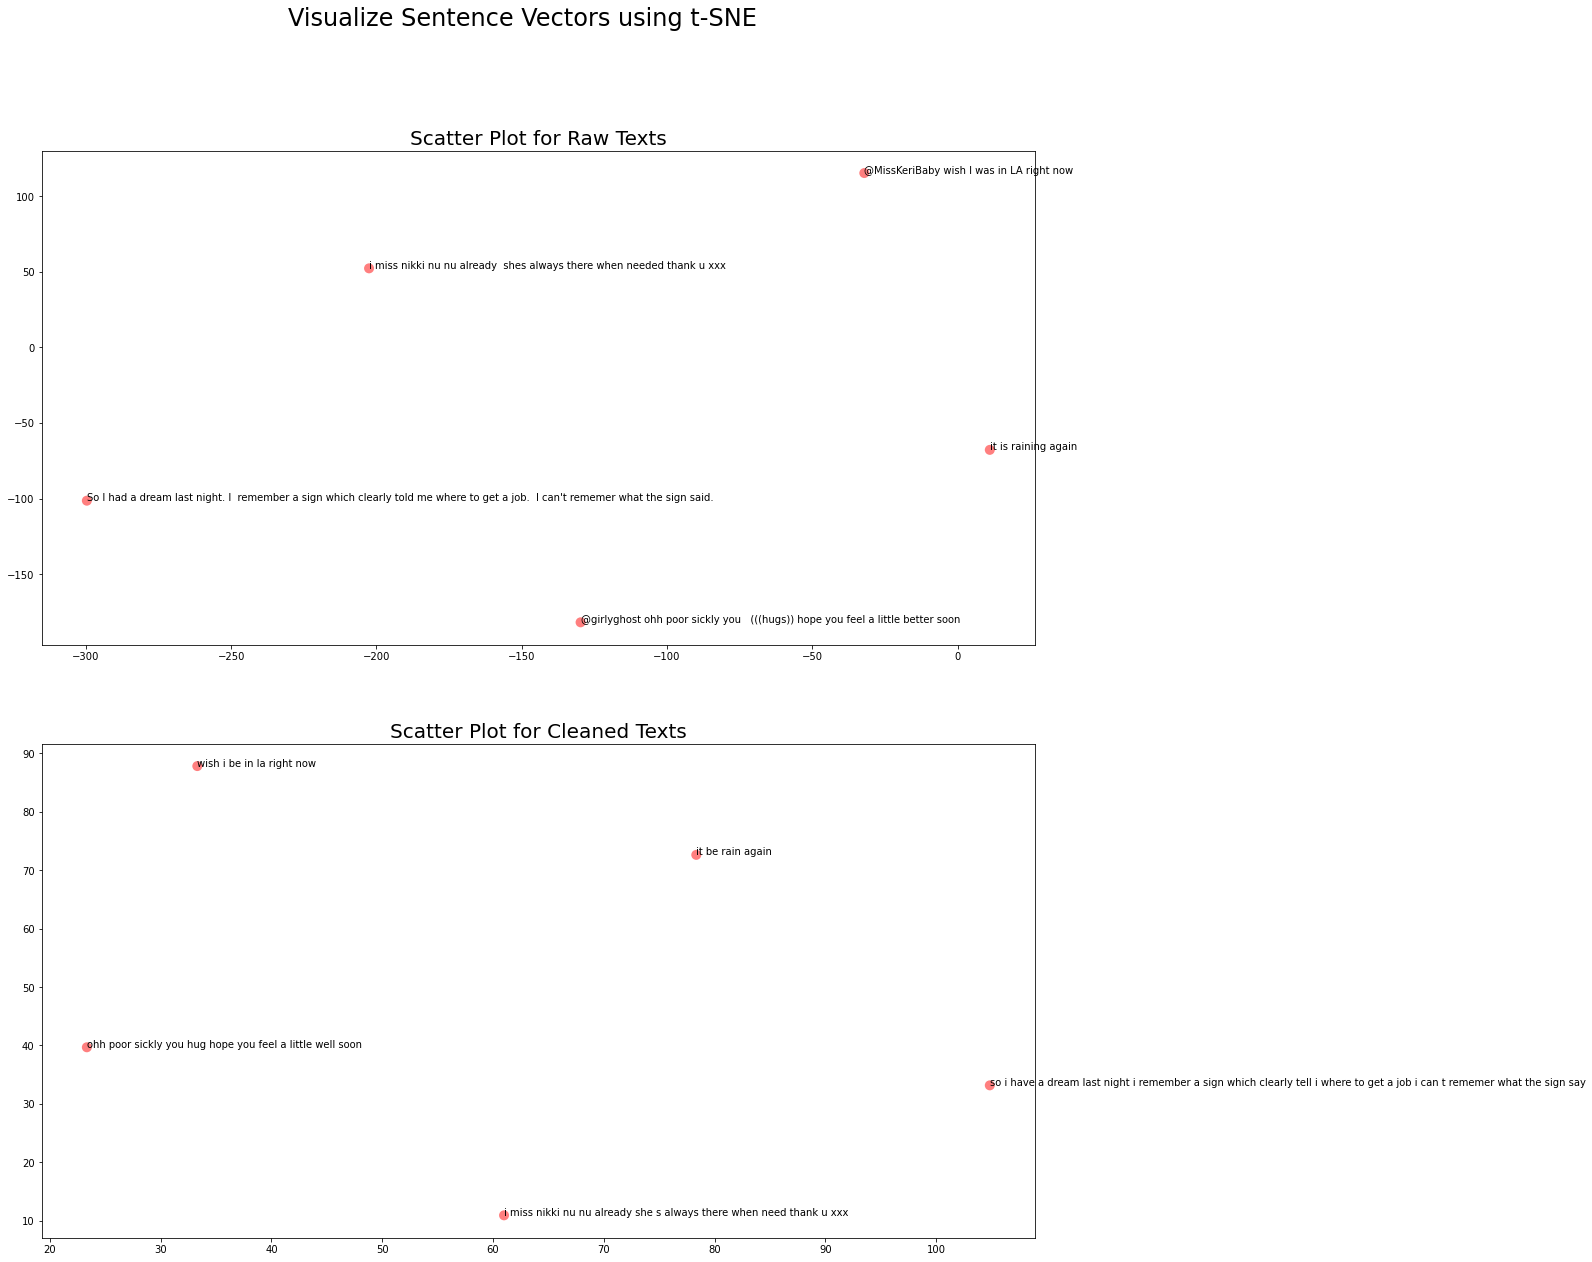

In [20]:
from sklearn.manifold import TSNE 

# Extract 2 componets using t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=4000)
tsne_ac = tsne.fit_transform(X_ac)
tsne_bc = tsne.fit_transform(X_bc)

# Plot the 2 component side-by-side
review_ac = df_ac.review_ac
review_bc = df_bc.review_bc

fig, ax = plt.subplots(2, 1, figsize = (17.8, 10*2))
fig.suptitle('Visualize Sentence Vectors using t-SNE', fontsize= 24)


ax[0].scatter(tsne_bc[:,0],tsne_bc[:,1], s = 100,  c= df_bc["sentiment"].map(colors), 
            cmap = "coolwarm", edgecolor = "None", alpha=0.5)

ax[0].set_title('Scatter Plot for Raw Texts', fontsize= 20)
# Label the points using texts
for idx, txt in enumerate(review_bc):
    ax[0].annotate(txt, (tsne_bc[idx, 0],tsne_bc[idx, 1]))

ax[1].scatter(tsne_ac[:,0],tsne_ac[:,1], s = 100,  c= df_ac["sentiment"].map(colors),
            cmap = "coolwarm", edgecolor = "None", alpha=0.5)
# Label the points using texts
for idx, txt in enumerate(review_ac):
    ax[1].annotate(txt, (tsne_ac[idx, 0],tsne_ac[idx, 1]))
ax[1].set_title('Scatter Plot for Cleaned Texts', fontsize= 20)
plt.show()